In [ ]:
!pip install pymcr

In [ ]:
!pip install kennard-stone

In [1012]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, KFold
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score, make_scorer
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [1013]:
Components = ['NO', 'N2O', 'NH3', 'CO']

In [ ]:
component_names = ['no', 'n2o', 'nh3', 'co']

In [ ]:
data = pd.read_csv('data.csv')

In [1014]:
dataNO = pd.read_csv('dataNO.csv')
dataN2O = pd.read_csv('dataN2O.csv')
dataNH3 = pd.read_csv('dataNH3.csv')
dataCO = pd.read_csv('dataCO.csv')

In [1015]:
proportion_c = ['no_p', 'n2o_p', 'nh3_p', 'co_p']

In [1016]:
data_q = [dataNO, dataN2O, dataNH3, dataCO]

In [1017]:
total_scores = {}

In [1018]:
total_scores['NO'] = pd.DataFrame(columns = [['BPNN', 'SVR', 'RF', 'GB']], index=[['r2', 'MSE']])
total_scores['N2O'] = pd.DataFrame(columns = [['BPNN', 'SVR', 'RF', 'GB']], index=[['r2', 'MSE']])
total_scores['NH3'] = pd.DataFrame(columns = [['BPNN', 'SVR', 'RF', 'GB']], index=[['r2', 'MSE']])
total_scores['CO'] = pd.DataFrame(columns = [['BPNN', 'SVR', 'RF', 'GB']], index=[['r2', 'MSE']])

#Quantitative

##BPNN

In [1044]:
for i, comp in enumerate(data_q):
    threes = comp[comp[component_names].sum(axis=1) == 3]
    yt = threes[proportion_c[i]] * 100
    Xt = threes.iloc[:, :3000]

    kf = KFold(n_splits = 5, shuffle = True)
    scores_r2 = []
    scores_mse = []
    Xt = np.array(Xt)
    yt = np.array(yt)
    for j, ((train_index, test_index)) in enumerate(kf.split(Xt)):
        X_train, y_train, X_test, y_test = Xt[train_index], yt[train_index], Xt[test_index], yt[test_index]

        model = nn.Sequential(
              nn.Linear(3000, 5),
              nn.ReLU(),
              nn.Linear(5, 10),
              nn.ReLU(),
              nn.Linear(10, 20),
              nn.ReLU(),
              nn.Linear(20, 1),
            )
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.MSELoss()

        ss = StandardScaler()

        X_train = ss.fit_transform(X_train)

        X_train = torch.from_numpy(np.array(X_train)).float()
        y_train = torch.from_numpy(np.array(y_train)).float().reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        model.train()
        for epoch in range(1000):
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        transformed = ss.transform(X_test)
        predicted = model(torch.tensor(transformed).float()).detach().numpy()

        scores_r2.append(r2_score(predicted, y_test))
        scores_mse.append(np.mean(np.square((predicted - y_test))))
    total_scores[Components[i]].loc['r2', 'BPNN'] = np.mean(scores_r2)
    total_scores[Components[i]].loc['MSE', 'BPNN'] = np.mean(scores_mse)

##SVR

In [1045]:
for i, comp in enumerate(data_q):
    threes = comp[comp[component_names].sum(axis=1) == 3]
    yt = threes[proportion_c[i]] * 100
    Xt = threes.iloc[:, :3000]
    model = make_pipeline(StandardScaler(), SVR())
    scores = cross_validate(model, Xt, yt, scoring = ['r2', 'neg_mean_squared_error'])
    total_scores[Components[i]].loc['r2', 'SVR'] = np.mean(scores['test_r2'])
    total_scores[Components[i]].loc['MSE', 'SVR'] = np.mean(np.absolute(scores['test_neg_mean_squared_error'].mean()))

##Tree

In [1046]:
for i, comp in enumerate(data_q):
    threes = comp[comp[component_names].sum(axis=1) == 3]
    yt = threes[proportion_c[i]] * 100
    Xt = threes.iloc[:, :3000]
    model = RandomForestRegressor(max_depth=8)
    scores = cross_validate(model, Xt, yt, scoring = ['r2', 'neg_mean_squared_error'])
    total_scores[Components[i]].loc['r2', 'RF'] = np.mean(scores['test_r2'])
    total_scores[Components[i]].loc['MSE', 'RF'] = np.mean(np.absolute(scores['test_neg_mean_squared_error'].mean()))

##Boosting

In [1047]:
for i, comp in enumerate(data_q):
    threes = comp[comp[component_names].sum(axis=1) == 3]
    yt = threes[proportion_c[i]] * 100
    Xt = threes.iloc[:, :3000]
    model = make_pipeline(StandardScaler(), GradientBoostingRegressor(max_depth=5))
    scores = cross_validate(model, Xt, yt, scoring = ['r2', 'neg_mean_squared_error'])
    total_scores[Components[i]].loc['r2', 'GB'] = np.mean(scores['test_r2'])
    total_scores[Components[i]].loc['MSE', 'GB'] = np.mean(np.absolute(scores['test_neg_mean_squared_error'].mean()))

In [1048]:
total_scores['NO']

,BPNN,SVR,RF,GB
r2,0.990891,0.843172,0.981062,0.979232
MSE,3.545056,60.889813,7.405055,8.113948


In [1049]:
total_scores['N2O']

,BPNN,SVR,RF,GB
r2,0.993271,0.871454,0.981126,0.982734
MSE,2.662373,49.898948,7.404174,6.768602


In [1050]:
total_scores['NH3']

,BPNN,SVR,RF,GB
r2,0.997318,0.874128,0.956518,0.956135
MSE,1.015977,48.874073,16.906291,17.067248


In [1051]:
total_scores['CO']

,BPNN,SVR,RF,GB
r2,0.989346,0.833115,0.983308,0.984896
MSE,4.208809,64.799992,6.543963,5.918498


In [1052]:
final = pd.DataFrame(columns=total_scores['CO'].columns, index = total_scores['CO'].index)

In [1053]:
for i in range(2):
    for j in range(4):
        q = 0
        for k in Components:
            q += total_scores[k].iloc[i, j]
        final.iloc[i, j] = q / 4


In [1054]:
final

,BPNN,SVR,RF,GB
r2,0.992707,0.855467,0.975504,0.975749
MSE,2.858054,56.115706,9.56487,9.467074


From the scores we can see that BPNN performs best, RF and GB do the job just slightly worse and SVR gives quite bad results compared to the other approaches.

# Qualitative

##SVD

In [ ]:
threes = data[data[component_names].sum(axis=1) == 3]

In [ ]:
groups = list(itertools.combinations(component_names, 3))

In [ ]:
groupsv = []

In [ ]:
for i in groups:
    ilist = list(i)
    gr = threes[threes[ilist].sum(axis=1) == 3]
    groupsv.append(gr.drop(['props', 'no', 'n2o', 'nh3', 'co', 'no_p', 'n2o_p', 'nh3_p', 'co_p', 't', 'p'], axis=1))

In [ ]:
logs = []

In [ ]:
result_vals = []
for i in groupsv:
    s = np.array(svd(i, compute_uv=False))
    diag = s * 100 / np.sum(s)
    logs.append([s, diag])
    num_of_vals = len(diag[diag > 2.5])
    result_vals.append(num_of_vals)

In [ ]:
result_vals

[3, 3, 3, 3]

##SIMPLISMA

In [ ]:
def scale(row):
    tmp = (row - np.min(row))/(np.max(row) - np.min(row))
    return tmp

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.optimize as optimize

nPure = 3
noise = 1

#Main Algorithm
def simplisma(d, nr, error):

	def wmat(c,imp,irank,jvar):
		dm=np.zeros((irank+1, irank+1))
		dm[0,0]=c[jvar,jvar]

		for k in range(irank):
			kvar=np.int32(imp[k])

			dm[0,k+1]=c[jvar,kvar]
			dm[k+1,0]=c[kvar,jvar]

			for kk in range(irank):
				kkvar=np.int32(imp[kk])
				dm[k+1,kk+1]=c[kvar,kkvar]

		return dm

	nrow,ncol=d.shape

	dl = np.zeros((nrow, ncol))
	imp = np.zeros(nr)
	mp = np.zeros(nr)

	w = np.zeros((nr, ncol))
	p = np.zeros((nr, ncol))
	s = np.zeros((nr, ncol))

	error=error/100
	mean=np.mean(d, axis=0)
	error=np.max(mean)*error

	s[0,:]=np.std(d, axis=0)
	w[0,:]=(s[0,:]**2)+(mean**2)
	p[0,:]=s[0,:]/(mean+error)

	imp[0] = np.int32(np.argmax(p[0,:]))
	mp[0] = p[0,:][np.int32(imp[0])]

	l=np.sqrt((s[0,:]**2)+((mean+error)**2))

	for j in range(ncol):
		dl[:,j]=d[:,j]/l[j]

	c=np.dot(dl.T,dl)/nrow

	w[0,:]=w[0,:]/(l**2)
	p[0,:]=w[0,:]*p[0,:]
	s[0,:]=w[0,:]*s[0,:]

	print('purest variable 1: ', np.int32(imp[0]+1), mp[0])

	for i in range(nr-1):
		for j in range(ncol):
			dm=wmat(c,imp,i+1,j)
			w[i+1,j]=np.linalg.det(dm)
			p[i+1,j]=w[i+1,j]*p[0,j]
			s[i+1,j]=w[i+1,j]*s[0,j]

		imp[i+1] = np.int32(np.argmax(p[i+1,:]))
		mp[i+1] = p[i+1,np.int32(imp[i+1])]

		print('purest variable '+str(i+2)+': ', np.int32(imp[i+1]+1), mp[i+1])

	sp=np.zeros((nrow, nr))

	for i in range(nr):
		sp[0:nrow,i]=d[0:nrow,np.int32(imp[i])]

	plt.subplot(3, 1, 2)
	plt.plot(sp)
	plt.title('Estimate Components')

	concs = np.dot(np.linalg.pinv(sp), d)

	plt.subplot(3, 1, 3)
	for i in range(nr):
		plt.plot(concs[i])
	plt.title('Concentrations')
	plt.show()

	return sp, concs

In [ ]:
groups

[('no', 'n2o', 'nh3'),
 ('no', 'n2o', 'co'),
 ('no', 'nh3', 'co'),
 ('n2o', 'nh3', 'co')]

purest variable 1:  181 4.714880216638137
purest variable 2:  130 1.0229669433967055
purest variable 3:  61 0.01689153263168258


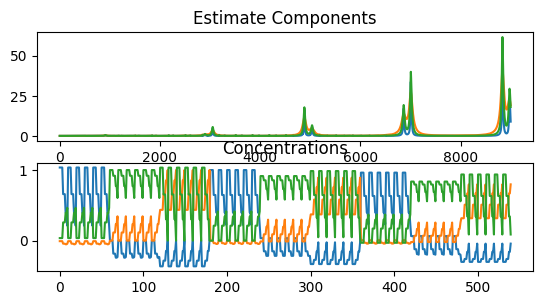

purest variable 1:  1 3.2484018259286027
purest variable 2:  130 0.6010643156520601
purest variable 3:  461 0.01706037208206647


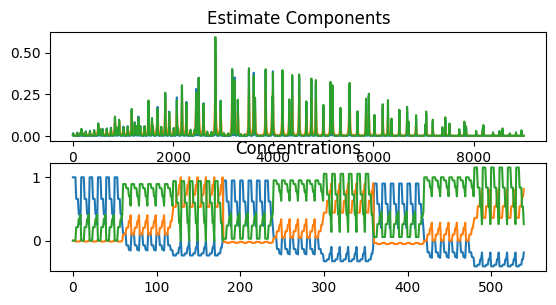

purest variable 1:  181 4.704118097133017
purest variable 2:  130 1.0204980106811923
purest variable 3:  61 0.016853638801745313


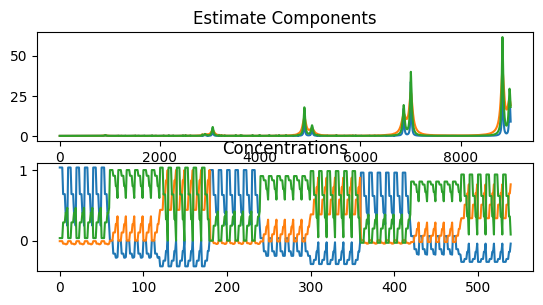

purest variable 1:  191 4.734827221927173
purest variable 2:  140 1.0280057288918196
purest variable 3:  61 0.016976565693072074


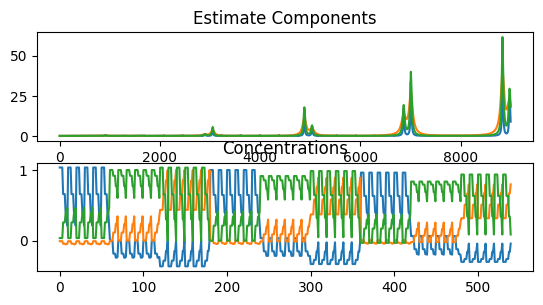

In [ ]:
for i in groupsv:
    sp, concs = simplisma(np.array(i).T, nPure, 5)

## Approximation

In [ ]:
from pymcr.mcr import McrAR
from pymcr.regressors import NNLS
from pymcr.constraints import ConstraintNonneg, ConstraintNorm
import kennard_stone as ks
from sklearn.linear_model import Lasso
from sklearn.metrics import pairwise_distances

In [ ]:
def ks3(d, metric_):
    d = np.array(d)
    pwd = pairwise_distances(d, metric=metric_)
    i = np.argmax(pwd) // pwd.shape[1]
    j = np.argmax(pwd) % pwd.shape[0]
    res = np.vstack([d[i], d[j]])
    d = np.delete(d, [i, j], 0)
    pwd = pairwise_distances(d, res, metric=metric_)
    k = np.argmax(np.min(pwd, axis = 1))
    res = np.vstack([res, d[k]])
    return res

In [ ]:
size = 3001
comp = 'no'

In [ ]:
def ar_ks(comp, size, z=0, x=1, v=2):
    threes = data[data[component_names].sum(axis=1) == 3]
    spectra = np.array(data[data[comp]==0].drop(['props', 'no', 'n2o', 'nh3', 'co', 'no_p', 'n2o_p', 'nh3_p', 'co_p', 't', 'p'], axis=1))[:,:size]

    ones = data[data[component_names].sum(axis=1) == 1]

    spectraNO = np.array(threes[threes[comp]==0].drop(['props', 'no', 'n2o', 'nh3', 'co', 'no_p', 'n2o_p', 'nh3_p', 'co_p', 't', 'p'], axis=1))[:,:size]

    est_pure_spectra = ks3(spectra[:,:3001], metric_="euclidean")
    est_pure_spectra = np.array(est_pure_spectra)

    mcrar = McrAR(max_iter=1, st_regr=NNLS(), c_regr='NNLS',
                c_constraints=[ConstraintNonneg()])
    mcrar.fit(spectraNO, ST=est_pure_spectra, st_fix=[0,1,2])

    ps = ones[(ones['t'] == 296) * (ones['p'] == 1) * (ones[comp] == 0)]

    with plt.style.context(('seaborn-whitegrid')):
        fig, ax = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)
        ax[0,0].plot(np.arange(10, (10 + size // 100)+0.01, 0.01), scale(mcrar.ST_[0]).T, 'k', lw=5)
        ax[0,0].plot(np.arange(10, (10 + size // 100)+0.01, 0.01), scale(ps.iloc[z, :size]).T, 'b')

        ax[0,0].set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=14)
        ax[0,0].set_ylabel("AU scaled", fontsize=14)


        ax[0,1].plot(np.arange(10, (10 + size // 100)+0.01, 0.01), scale(mcrar.ST_[1]).T, 'k', lw=5)
        ax[0,1].plot(np.arange(10, (10 + size // 100)+0.01, 0.01), scale(ps.iloc[x, :size]).T, 'b')

        ax[0,1].set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=14)
        ax[0,1].set_ylabel("AU scaled", fontsize=14)


        ax[1,0].plot(np.arange(10, (10 + size // 100)+0.01, 0.01), scale(mcrar.ST_[2]).T, 'k', lw=5)
        ax[1,0].plot(np.arange(10, (10 + size // 100)+0.01, 0.01), scale(ps.iloc[v, :size]).T, 'b')

        ax[1,0].set_xlabel("Wavenumber (cm$^{-1}$)", fontsize=14)
        ax[1,0].set_ylabel("AU scaled", fontsize=14)

        plt.show()

In [ ]:
def coder(a):
    return a[:,0] + a[:,1] * 2 + a[:,2] * 4 + a[:,3] * 8


def ar_fixed(feature, size):
    threes = data[data[component_names].sum(axis=1) == 3]
    ones = data[data[component_names].sum(axis=1) == 1]
    ps_all = ones[(ones['t'] == 296) * (ones['p'] == 1)].iloc[:, :size]
    spectrac = np.array(threes[threes[feature]==0].drop(['props', 'no', 'n2o', 'nh3', 'co', 'no_p', 'n2o_p', 'nh3_p', 'co_p', 't', 'p'], axis=1))[:,:size]
    c = np.array(threes[threes[feature]==0].loc[:,['no', 'n2o', 'nh3', 'co']])
    mcrar = McrAR(max_iter=1, st_regr=Lasso(), c_regr='OLS',
              c_constraints=[ConstraintNonneg(), ConstraintNorm()])
    mcrar.fit(spectrac, ST=ps_all, st_fix=[0, 1, 2, 3])
    est_c = mcrar.C_[:,:]
    mask = np.apply_along_axis(lambda x: x > np.partition(x, 0)[0], 1, est_c)
    est_c[mask] = 1
    est_c[np.logical_not(mask)] = 0
    print(np.sum(coder(est_c) == coder(np.array(c)))/len(coder(c)))

Two approaches:

**ar_fixed** - find regression on true components and count component as present if its evaluated concentration is in top 3 (resulting value of SVD) obtained conentration values. Function returns accuracy score

**ar_ks** - find spectra of components using kennard-stone algorithm with value of pure components obtained from SVD. Function returns set of plots with black - predicted and blue - true spectra. The spectra are scaled

In [ ]:
ar_fixed('no', 3001)

Max iterations reached (1).


INFO:pymcr.mcr:Max iterations reached (1).


1.0


In [ ]:
ar_fixed('n2o', 3001)

Max iterations reached (1).


INFO:pymcr.mcr:Max iterations reached (1).


1.0


In [ ]:
ar_fixed('nh3', 3001)

Max iterations reached (1).


INFO:pymcr.mcr:Max iterations reached (1).


1.0


In [ ]:
ar_fixed('co', 3001)

Max iterations reached (1).


INFO:pymcr.mcr:Max iterations reached (1).


1.0


ar_fixed yields perfect predictions of component presence

Max iterations reached (1).


INFO:pymcr.mcr:Max iterations reached (1).


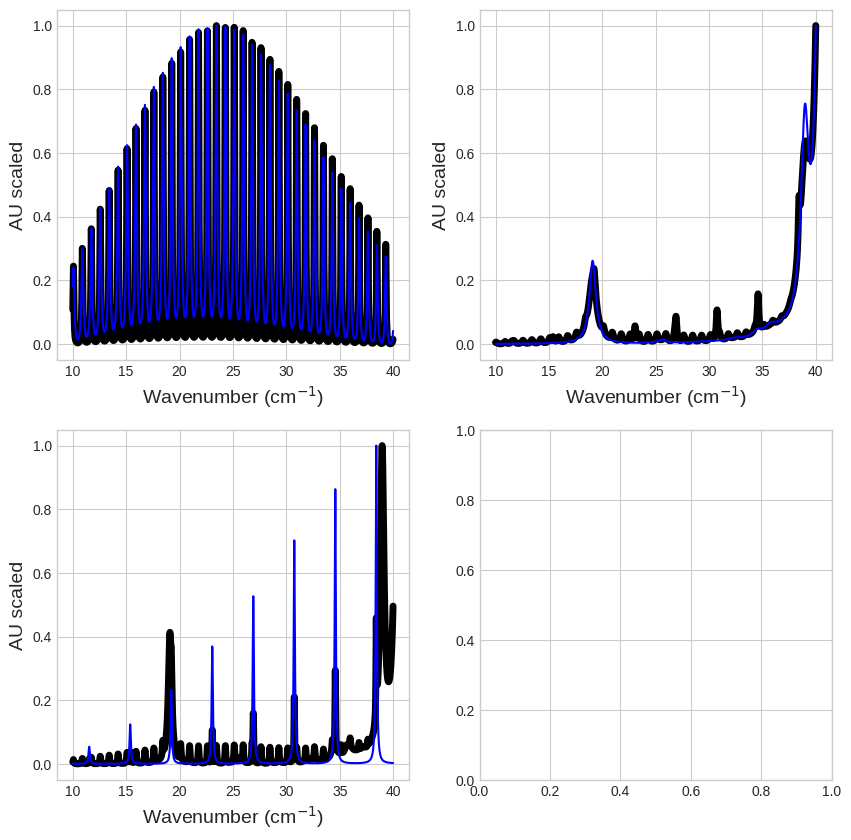

In [ ]:
ar_ks('no', 3001)

Max iterations reached (1).


INFO:pymcr.mcr:Max iterations reached (1).


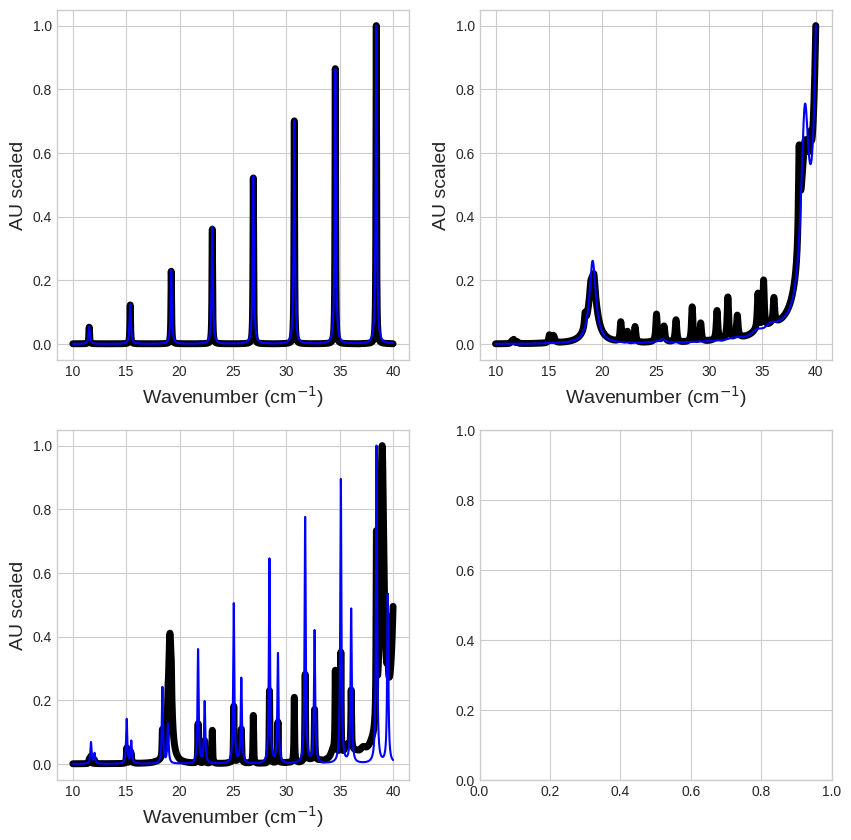

In [ ]:
ar_ks('n2o', 3001, 2, 1, 0)

Max iterations reached (1).


INFO:pymcr.mcr:Max iterations reached (1).


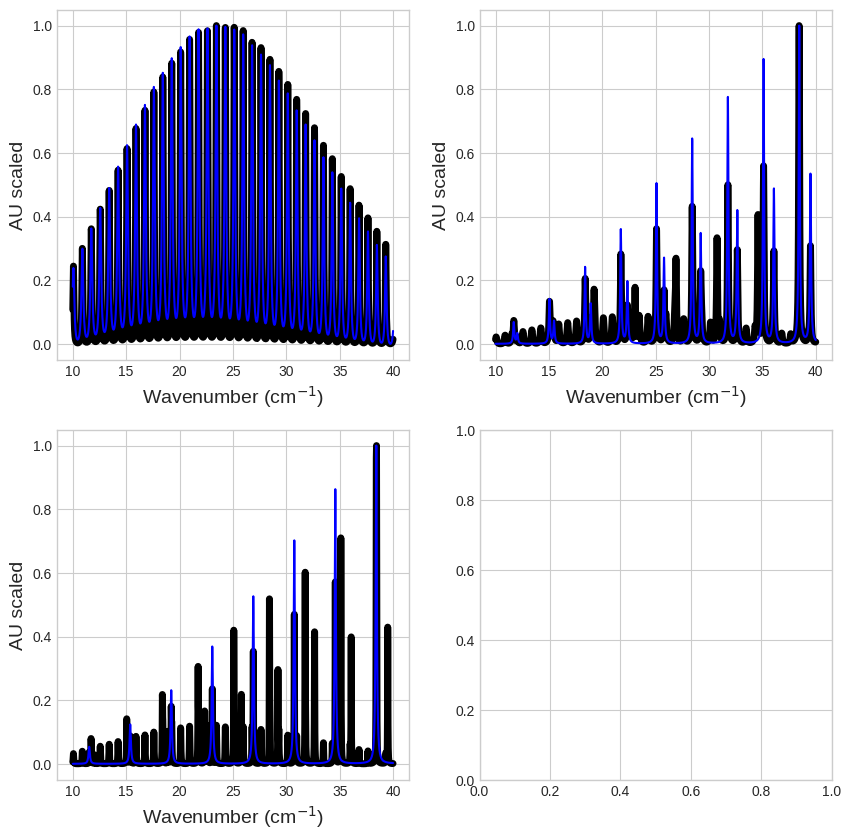

In [ ]:
ar_ks('nh3', 3001, 1, 0, 2)

Max iterations reached (1).


INFO:pymcr.mcr:Max iterations reached (1).


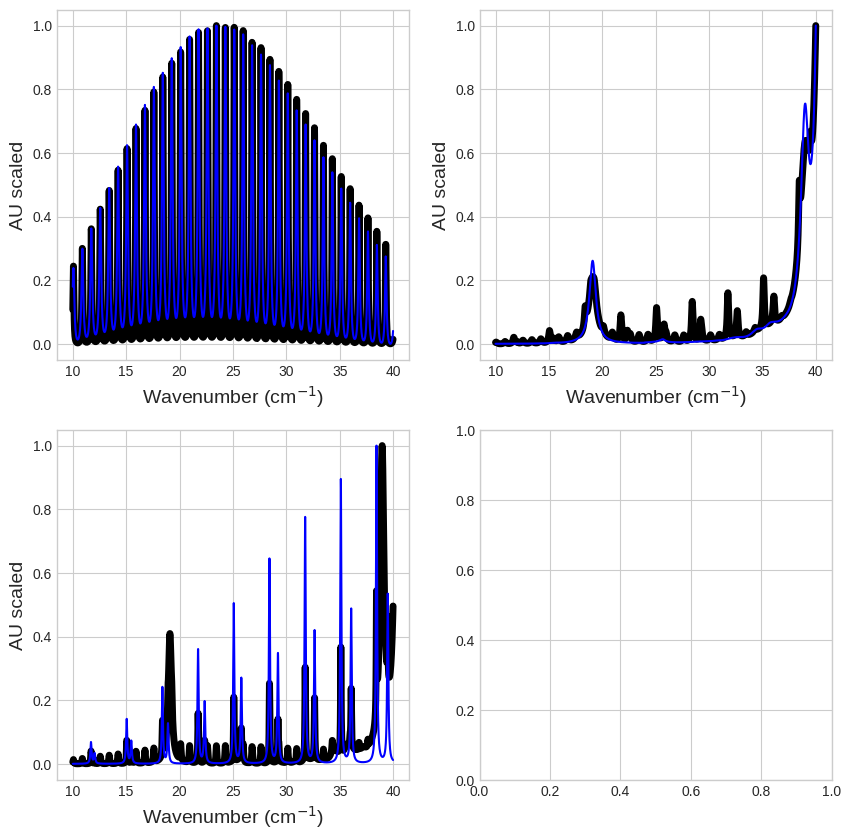

In [ ]:
ar_ks('co', 3001, 1, 2, 0)

ar_ks manages to find peaking values, which is important for component spectra identification. However, it still has some false peaks (that are generally smaller than the true ones)